<h1><center>Bandpass Filter Parameter Estimation using PyMC</center></h1>
<h2><center>Solving the Model System in parts</center></h2>
The approach to solving the bandpass parameter estimation problem is to break it down into two parts, essentially simulating its response as a *lowpass filter* followed by a *highpass filter*. Since the last update, I've also simplified the model further keeping only the essential differential equations. Intracellular concentrations of metabolites not directly affected by the bandpass filter like $ [LacI]$ and $[AmpR]$ are considered to be constant. I've also not taken into consideration *Hitchhicker protein's* mechanism with the assumption that it will only modulate some of the constants optimized and not have an effect on the structure of the ODEs.

The model equations are as follows:

$\frac{d[BLA]}{dt}= \frac{\beta_{BLA}}{1+\Big(\frac{[LacI]_{T}\Big/K_{LacI}}{ 1+\big( 
[IPTG]\big/K_{IPTG}\big) ^{\eta_{IPTG}} }\Big) ^{\eta_{LacI}}}- \gamma _{BLA}[BLA]$ 

$\frac{d[Amp]}{dt}= k_{t,Amp}([Amp]_{ext}-[Amp] ) -\frac{k_{cat,BLA}[BLA][Amp]}{K_{m,BLA}+[Amp] }$ 

[//]:($\frac{d[aMPp]}{dt}= k_{Amp}\lbrack Amp\rbrack - \gamma _{aMPp}\lbrack 
aMPp\rbrack $)

$\frac{d[TetC]}{dt}= \frac{\beta _{TetC}}
{1+ \Big( \frac{[AmpR]\Big/K_{AmpR}}{1+\big([Amp]\big/K_{Amp}\big) ^{\eta {Amp}} }\big) ^{\eta _{AmpR}}}- \gamma _{TetC}[TetC]$

$\frac{d[Tet]}{dt}= k_{t,Tet}([Tet]_{ext}-[Tet]) - k_{TetC}[TetC][Tet]$

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
exp=np.genfromtxt("expdata.txt", delimiter='\t')
amp0=np.genfromtxt("amp0.txt", delimiter='\t')
iptg=exp[:,0]
tet0=exp[:,1]
MIC_exp=exp[:,2]
IND_exp=exp[:,3]
amp0=np.sort(amp0)

In [3]:
#defining prior distributions of our unknown variables 
constants_prob = pm.Uniform('constants_prob', 0.001, 1.0,size=15)


@pm.deterministic
def bandpass(constants_prob=constants_prob,iptg=iptg,tet0=tet0,amp0=amp0):
    bg_bla=constants_prob[0]*5000     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*50         #0.01 #uM combo of laci/kd_laci
    #kd_laci=constants_prob[2]*5e-3   #7.8e-4 #uM
    n_laci=constants_prob[2]*5        #2.5
    kd_iptg=constants_prob[3]*50      #25 #uM
    n_iptg=constants_prob[4]*5        #2
    #kcat=constants_prob[6]*5e6       #2.82e5 #1/m
    km=constants_prob[5]*500          #100 #uM
    ktr=constants_prob[6]*1e-2        #1e3 Combo of ktr and kcat
    MIC_int=constants_prob[7]*5       #amp[0,5]
    bg_tetc=constants_prob[8]*1000    #10/0.1 #uM/min combo of beta and gamma
    ampr=constants_prob[9]*100        #0.1/1e-2 #uM combo of ampr/kd_ampr
    n_ampr=constants_prob[10]*5       #1
    kd_amp=constants_prob[11]*0.5      #0.5 #uM
    n_amp=constants_prob[12]*5        #1
    k_tet=constants_prob[13]*10     #10
    MIC_tet_int=constants_prob[14]*5  #2
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<=amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]

    #amp=amp*349.41/1000 #convert to ug/ml

    MIC_mod=np.zeros(len(iptg))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if amp[i,j]>=MIC_int:
                break
            MIC_mod[i]=amp0[j]

            
    tetc=np.zeros((len(iptg),len(amp0)))
    tet=np.zeros((len(iptg),len(amp0)))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            D_amp=1+(amp[i,j]/kd_amp)**n_amp
            D_ampr=1+(ampr/(D_amp))**n_ampr
            tetc[i,j]=bg_tetc/D_ampr
            tet[i,j]=tet0[i]*k_tet/(k_tet+tetc[i,j])

    #tet=tet0*k_tet_dif/(k_tet_dif+k_tet_act*tetc)
    MIC_tet_mod=np.zeros(len(iptg))[:,None]
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if tet[i,j]<=MIC_tet_int:
                break
            MIC_tet_mod[i]=amp0[j]
            
    modeloutput=np.zeros((len(iptg),2))
    for i in range(len(iptg)):
        modeloutput[i,0]=MIC_mod[i]
        modeloutput[i,1]=MIC_tet_mod[i]
    return modeloutput

In [4]:
comp_exp=exp[:,2:]

observed_MIC = pm.Normal('observed_MIC', mu=bandpass,tau=1000,value=comp_exp, observed=True)

In [5]:
model = pm.Model([constants_prob,bandpass,observed_MIC])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(20000, burn=4000, thin=50)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


 [-----------------100%-----------------] 20000 of 20000 complete in 130.4 sec

In [6]:
#MCMC samples turned to arrays
constants_samples=mcmc.trace('constants_prob')[:]
bandpass_samples=mcmc.trace('bandpass')[:]

In [7]:
model_result=bandpass_samples.mean(axis=0)
mod_comp=np.zeros((len(iptg),6))
mod_comp[:,0]=iptg;mod_comp[:,1]=tet0
mod_comp[:,2]=comp_exp[:,0];mod_comp[:,4]=comp_exp[:,1]
mod_comp[:,3]=model_result[:,0];mod_comp[:,5]=model_result[:,1];
pd.DataFrame(mod_comp,columns=['IPTG','Tet','Highpass(Exp)','Highpass(Model)','Lowpass(Exp)','Lowpass(Model)'])

,IPTG,Tet,Highpass(Exp),Highpass(Model),Lowpass(Exp),Lowpass(Model)
0,90.0,18.0,56.25,56.25,1.758,1.758000
1,180.0,18.0,225.00,225.00,3.516,3.516000
2,270.0,18.0,225.00,225.00,7.031,7.031000
3,450.0,18.0,450.00,450.00,7.031,7.031000
4,675.0,18.0,450.00,450.00,7.031,7.031000
5,900.0,18.0,450.00,450.00,7.031,7.031000
6,270.0,4.5,225.00,225.00,0.000,0.000000
7,270.0,9.0,450.00,225.00,0.000,0.000278
8,270.0,13.5,225.00,225.00,3.516,3.516000
9,270.0,18.0,225.00,225.00,7.031,7.031000


Plotting constants_prob_0
Plotting constants_prob_1
Plotting constants_prob_2
Plotting constants_prob_3
Plotting constants_prob_4
Plotting constants_prob_5
Plotting constants_prob_6
Plotting constants_prob_7
Plotting constants_prob_8
Plotting constants_prob_9
Plotting constants_prob_10
Plotting constants_prob_11
Plotting constants_prob_12
Plotting constants_prob_13
Plotting constants_prob_14


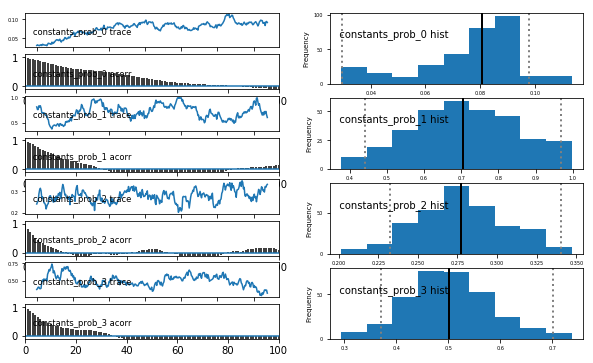

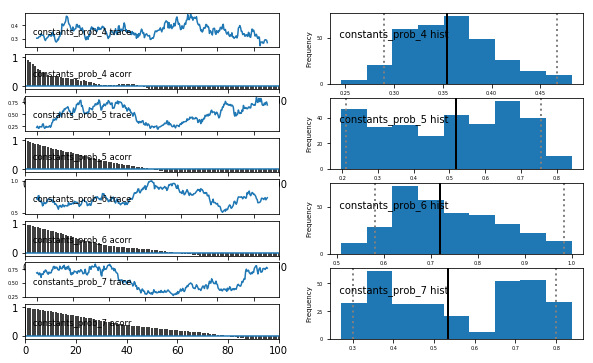

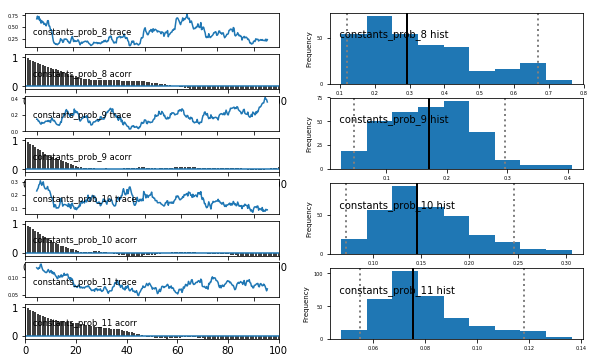

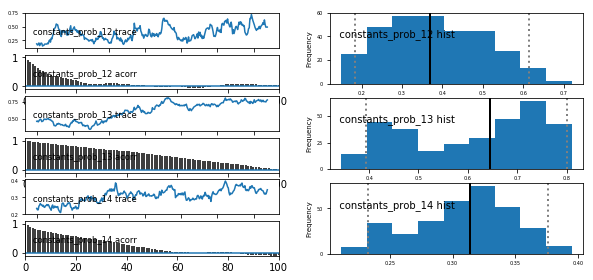

In [12]:
from pymc.Matplot import plot as mcplot
mcplot(mcmc.trace("constants_prob",3), common_scale=False);

0.038613420000301983

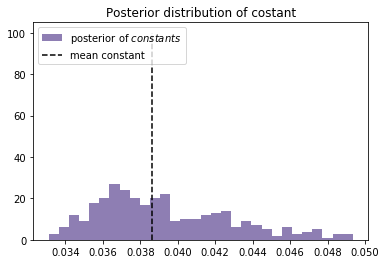

In [26]:
#Histogram of variable 1:kcat
i=14
plt.hist(constants_samples[:,i], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $constants$", color="#7A68A6");
plt.vlines(np.median(constants_samples[:,i]), 0, 100, linestyle="--", label="mean constant")
plt.legend(loc="upper left")
plt.title("Posterior distribution of costant")
np.median(constants_samples[:,i])

In [13]:
np.savetxt('constants.txt',constants_samples,delimiter='\t')

In [28]:
bandpass_samples.mean(axis=0)

array([[  56.25      ,    1.59327812],
       [ 225.        ,    3.36217812],
       [ 225.        ,    6.3334875 ],
       [ 450.        ,    6.99804375],
       [ 450.        ,    6.99804375],
       [ 450.        ,    7.00902812],
       [ 225.        ,    0.        ],
       [ 225.        ,    0.        ],
       [ 225.        ,    0.        ],
       [ 225.        ,    6.3334875 ],
       [ 225.        ,    7.031     ],
       [ 225.        ,   14.063     ]])

In [40]:
comp_exp

array([[  56.25 ,    1.758],
       [ 225.   ,    3.516],
       [ 225.   ,    7.031],
       [ 450.   ,    7.031],
       [ 450.   ,    7.031],
       [ 450.   ,    7.031],
       [ 225.   ,    0.   ],
       [ 450.   ,    0.   ],
       [ 225.   ,    3.516],
       [ 225.   ,    7.031],
       [ 225.   ,    7.031],
       [ 225.   ,   14.063]])

In [9]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()